# Analyzing New York City taxi data using big data tools

At 10.5 and later releases, ArcGIS Enterprise introduces [ArcGIS GeoAnalytics Server](http://server.arcgis.com/en/server/latest/get-started/windows/what-is-arcgis-geoanalytics-server-.htm) which provides you the ability to perform big data analysis on your infrastructure. This sample demonstrates the steps involved in performing an aggregation analysis on New York city taxi point data using ArcGIS API for Python.

The data used in this sample can be downloaded from [NYC Taxi & Limousine Commission website](http://www.nyc.gov/html/tlc/html/about/trip_record_data.shtml). For this sample, data for the months January & Febuary of 2015 were used, each averaging 12 million records.

**Note**: The ability to perform big data analysis is only available on ArcGIS Enterprise 10.5 licensed with a GeoAnalytics server and not yet available on ArcGIS Online.

## The NYC taxi data

To give you an overview, let us take a look at a subset with 2000 points published as a feature service.

In [1]:
import arcgis
from arcgis.gis import GIS

ago_gis = GIS() # Connect to ArcGIS Online as an anonymous user
search_subset = ago_gis.content.search("NYC_taxi_subset", item_type = "Feature Layer")
subset_item = search_subset[0]
subset_item

<Item title:"NYC_taxi_subset" type:Feature Layer Collection owner:atma.mani>

Let us bring up a map to display the data.


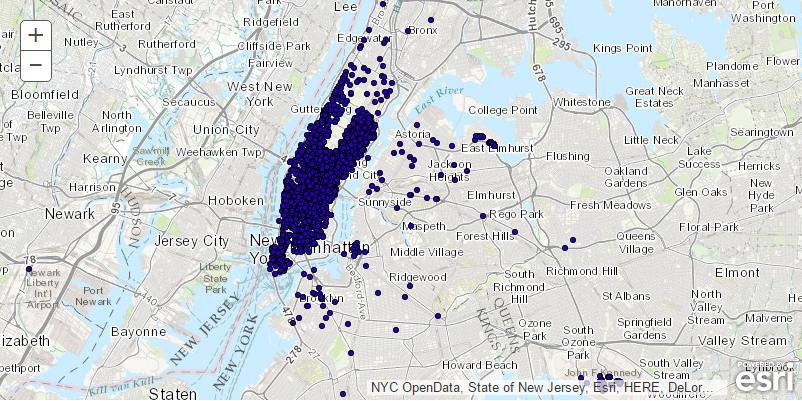

In [1]:
subset_map = ago_gis.map("New York, NY", zoomlevel=11)
subset_map

In [3]:
subset_map.add_layer(subset_item)

Let us access the feature layers using the `layers` property. We can select a specific layer from the laters list and explore its attribute table to understand the structure of our data. In the cell below, we use the feature layer's [`query()`](https://esri.github.io/arcgis-python-api/apidoc/html/arcgis.features.toc.html#arcgis.features.FeatureLayer.query) method to return the layer attribute information. The `query()` method returns a [`FeatureSet`](https://esri.github.io/arcgis-python-api/apidoc/html/arcgis.features.toc.html#featureset) object, which is a collection of individual [`Feature`](https://esri.github.io/arcgis-python-api/apidoc/html/arcgis.features.toc.html#feature) objects.

You can mine through the `FeatureSet` to inspect each individual `Feature`, read its attribute information and then compose a table of all features and their attributes. However, the `FeatureSet` object provides a much easier and more direct way to get that information. Using the [`df`](https://esri.github.io/arcgis-python-api/apidoc/html/arcgis.features.toc.html#arcgis.features.FeatureSet.df) property of a `FeatureSet`, you can load the attribute information as a [`pandas`](https://pandas.pydata.org/) [`dataframe`](http://pandas.pydata.org/pandas-docs/stable/dsintro.html#dataframe) object.

If you installed the ArcGIS API for Python through ArcGIS Pro or with the `conda install` command, you have the api and its dependencies, including the `pandas` package. The [`df`](https://esri.github.io/arcgis-python-api/apidoc/html/arcgis.features.toc.html#arcgis.features.FeatureSet.df) property will return a `dataframe`.  If you [installed without dependences](https://developers.arcgis.com/python/guide/install-and-set-up/#Install-without-Dependencies), you need to install the `pandas` Python package for the `df` property to return a dataframe. If you get an error that pandas cannot be found, you can install it by typing the following in your terminal that is running the jupyter notebook:

    conda install pandas

In [2]:
subset_feature_layer = subset_item.layers[0]

# query the attribute information. Limit to first 5 rows.
query_result = subset_feature_layer.query(where = 'OBJECTID < 5',
                                          out_fields = "*", 
                                          returnGeometry = False)

att_data_frame = query_result.sdf # get as a Pandas dataframe
att_data_frame

,Field1,OBJECTID,RateCodeID,VendorID,dropoff_latitude,dropoff_longitude,extra,fare_amount,improvement_surcharge,mta_tax,...,payment_type,pickup_latitude,pickup_longitude,store_and_fwd_flag,tip_amount,tolls_amount,total_amount,tpep_dropoff_datetime,tpep_pickup_datetime,trip_distance
0,3479320,1,1,2,40.782318,-73.980492,0.0,9.5,0.3,0.5,...,1,40.778149,-73.956291,N,2.1,0,12.4,1970-01-01 00:23:42.268943,1970-01-01 00:23:42.268218,1.76
1,8473342,2,1,2,40.769756,-73.950600,0.5,13.5,0.3,0.5,...,2,40.729458,-73.983864,N,0.0,0,14.8,1970-01-01 00:23:42.137577,1970-01-01 00:23:42.136892,3.73
2,10864374,3,1,2,40.753040,-73.985680,0.0,14.5,0.3,0.5,...,2,40.743740,-73.987617,N,0.0,0,15.3,1970-01-01 00:23:42.719906,1970-01-01 00:23:42.718711,2.84
3,7350094,4,1,2,40.765743,-73.954994,0.0,11.5,0.3,0.5,...,2,40.757507,-73.981682,N,0.0,0,12.3,1970-01-01 00:23:40.907558,1970-01-01 00:23:40.906601,2.18


The table above represents the attribute information available from the NYC dataset. Columns provide a wealth of infomation such as pickup and dropoff_locations, fares, tips, tolls, and trip distances which you can analyze to observe many interesting patterns. The full data dataset contains over 24 million points. To discern patterns out of it, let us aggregate the points into blocks of 1 square kilometer.

## Searching for big data file shares

To process data using GeoAnalytics Server, you need to have registered the data with your Geoanalytics Server. In this sample the data is in multiple csv files, which have been previously registered as a big data file share.

Let us connect to an ArcGIS Enterprise.

In [3]:
gis = GIS("https://pythonapi.playground.esri.com/portal", "arcgis_python", "amazing_arcgis_123")

Ensure that the Geoanalytics [is supported](https://esri.github.io/arcgis-python-api/apidoc/html/arcgis.geoanalytics.toc.html#arcgis.geoanalytics.is_supported) with our GIS.

In [4]:
arcgis.geoanalytics.is_supported()

True

Get the geoanalytics datastores and search it for the registered datasets:

In [5]:
datastores = arcgis.geoanalytics.get_datastores()

In [6]:
bigdata_fileshares = datastores.search()
bigdata_fileshares

[<Datastore title:"/bigDataFileShares/NYC_taxi_data15" type:"bigDataFileShare">,
 <Datastore title:"/bigDataFileShares/all_hurricanes" type:"bigDataFileShare">,
 <Datastore title:"/bigDataFileShares/hurricanes_1848_1900" type:"bigDataFileShare">]

NYC_taxi_data15 is registered as a `big data file share` with the Geoanalytics datastore, so we can reference it:

In [20]:
data_item = bigdata_fileshares[0]

## Registering big data file shares

The code below shows how a big data file share can be registered with the geoanalytics datastores, in case it's not already registered.

In [10]:
data_item = datastores.add_bigdata("NYCdata", r"\\pathway\to\data")

Big Data file share exists for NYCdata


Once a big data file share is created, the GeoAnalytics server processes all the valid file types to discern the schema of the data. This process can take a few minutes depending on the size of your data. Once processed, querying the [`manifest`](https://esri.github.io/arcgis-python-api/apidoc/html/arcgis.gis.toc.html?highlight=manifest#arcgis.gis.Datastore.manifest) property returns the schema. As you can see from below, the schema is similar to the subset we observed earlier in this sample.

In [23]:
data_item.manifest

{'datasets': [{'name': '2015',
   'format': {'quoteChar': '"',
    'fieldDelimiter': ',',
    'hasHeaderRow': True,
    'encoding': 'UTF-8',
    'recordTerminator': '\n',
    'type': 'delimited',
    'extension': 'csv'},
   'schema': {'fields': [{'name': 'VendorID',
      'type': 'esriFieldTypeBigInteger'},
     {'name': 'tpep_pickup_datetime', 'type': 'esriFieldTypeString'},
     {'name': 'tpep_dropoff_datetime', 'type': 'esriFieldTypeString'},
     {'name': 'passenger_count', 'type': 'esriFieldTypeBigInteger'},
     {'name': 'trip_distance', 'type': 'esriFieldTypeDouble'},
     {'name': 'pickup_longitude', 'type': 'esriFieldTypeDouble'},
     {'name': 'pickup_latitude', 'type': 'esriFieldTypeDouble'},
     {'name': 'RateCodeID', 'type': 'esriFieldTypeBigInteger'},
     {'name': 'store_and_fwd_flag', 'type': 'esriFieldTypeString'},
     {'name': 'dropoff_longitude', 'type': 'esriFieldTypeDouble'},
     {'name': 'dropoff_latitude', 'type': 'esriFieldTypeDouble'},
     {'name': 'payment

## Performing data aggregation

When you add a big data file share datastore, a corresponding item gets created on your portal. You can search for it like a regular item and query its layers.

In [28]:
search_result = gis.content.search("", item_type = "big data file share")
search_result

[<Item title:"bigDataFileShares_all_hurricanes" type:Big Data File Share owner:api_data_owner>,
 <Item title:"bigDataFileShares_hurricanes_1848_1900" type:Big Data File Share owner:arcgis_python>,
 <Item title:"bigDataFileShares_NYC_taxi_data15" type:Big Data File Share owner:api_data_owner>]

In [29]:
data_item = search_result[2]
data_item

<Item title:"bigDataFileShares_NYC_taxi_data15" type:Big Data File Share owner:api_data_owner>

In [26]:
data_item.layers

[<Layer url:"https://pythonapi.playground.esri.com/ga/rest/services/DataStoreCatalogs/bigDataFileShares_NYC_taxi_data15/BigDataCatalogServer/2015">]

In [27]:
year_2015 = data_item.layers[0]
year_2015

<Layer url:"https://pythonapi.playground.esri.com/ga/rest/services/DataStoreCatalogs/bigDataFileShares_NYC_taxi_data15/BigDataCatalogServer/2015">

### Aggregate points tool
You access the [`aggregate_points()`](https://esri.github.io/arcgis-python-api/apidoc/html/arcgis.geoanalytics.summarize_data.html#aggregate-points) tool in the [`summarize_data`](https://esri.github.io/arcgis-python-api/apidoc/html/arcgis.geoanalytics.summarize_data.html#) submodule of the [`geoanalytics`](https://esri.github.io/arcgis-python-api/apidoc/html/arcgis.geoanalytics.toc.html) module. In this example, we are using this tool to aggregate the numerous points into 1 kilometer square blocks. The tool creates a polygon feature layer in which each polygon contains aggregated attribute information from all the points in the input dataset that fall within that polygon. The output feature layer contains only polygons that contain at least one point from the input dataset. See [Aggregate Points](http://enterprise.arcgis.com/en/server/latest/get-started/windows/geoanalyticstool-aggregatepoints.htm) for details on using this tool.

In [30]:
from arcgis.geoanalytics.summarize_data import aggregate_points

The aggregate points tool requires that either:
  * the point layer is projected, or
  * the output or processing coordinate system is set to a Projected Coordinate System

We can query the layer `properties` to investigate the coordinate system of the point layer:

In [31]:
year_2015.properties['spatialReference']

{'wkid': 4326}

Since WGS84 (the coordinate system referred to by wkid 4326) is unprojected, we can use the [`arcgis.env`]() module to set the environment used in the tool processing. The [`process_spatial_reference`](https://esri.github.io/arcgis-python-api/apidoc/html/arcgis.env.html#arcgis.env.process_spatial_reference) environment setting controls the geometry processing of tools used by the API for Python. We can set this parameter to a projected coordinate system for tool processing:

> **NOTE:** The ouput layer for GeoAnalytics Tools always gets stored in the WGS84 Spatial Reference. See the `Usage notes` section of the [`help`](http://enterprise.arcgis.com/en/server/latest/get-started/windows/geoanalyticstool-aggregatepoints.htm) for more information.

In [32]:
arcgis.env.process_spatial_reference=3857

We can use the [`arcgis.env`](https://esri.github.io/arcgis-python-api/apidoc/html/arcgis.env.html) module to modify environment settings that geoprocessing and geoanalytics tools use during execution. Set [`verbose`](https://esri.github.io/arcgis-python-api/apidoc/html/arcgis.env.html#verbose) to `True` to return detailed messaging when running tools:

In [33]:
arcgis.env.verbose = True

Let's run the tool, specifying 1 kilometer squares as the polygons for which we want to aggregate information about all the NYC taxi information in each of those polygons:

In [34]:
agg_result = aggregate_points(year_2015, 
                              bin_type = 'square',
                              bin_size=1, 
                              bin_size_unit='Kilometers')

Submitted.
Executing...
Executing (AggregatePoints): AggregatePoints "Feature Set" Square 1 Kilometers # # # # # # # "{"serviceProperties": {"name": "Aggregate_Points_Analysis_PAMJHK", "serviceUrl": "https://pythonapi.playground.esri.com/server/rest/services/Hosted/Aggregate_Points_Analysis_PAMJHK/FeatureServer"}, "itemProperties": {"itemId": "5cf0d7a3676f496fbcb9f9d460242583"}}" "{"processSR": {"wkid": 3857}}"
Start Time: Thu May 24 17:16:38 2018
Using URL based GPRecordSet param: https://pythonapi.playground.esri.com/ga/rest/services/DataStoreCatalogs/bigDataFileShares_NYC_taxi_data15/BigDataCatalogServer/2015
{"messageCode":"BD_101033","message":"'pointLayer' will be projected into the processing spatial reference.","params":{"paramName":"pointLayer"}}
{"messageCode":"BD_101028","message":"Starting new distributed job with 236 tasks.","params":{"totalTasks":"236"}}
{"messageCode":"BD_101029","message":"0/236 distributed tasks completed.","params":{"completedTasks":"0","totalTasks":"

### Inspect the results

Let us create a map and load the processed result which is a feature layer item.


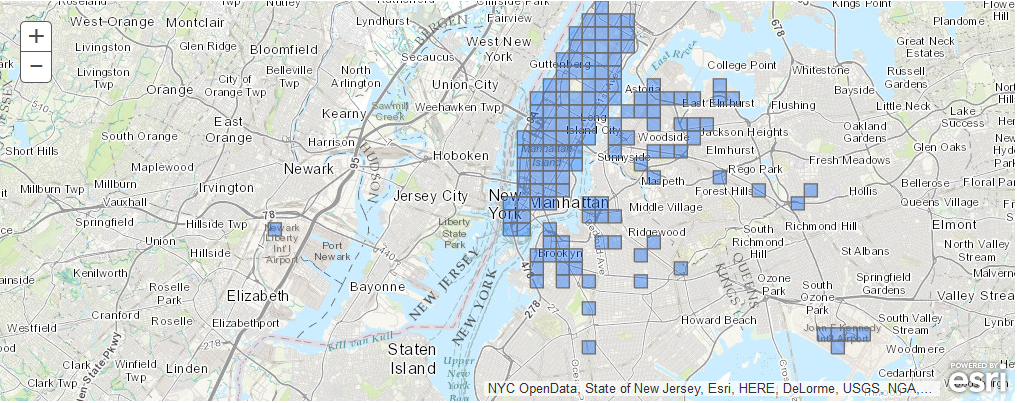

In [2]:
processed_map = gis.map('New York, NY', 11)
processed_map

In [36]:
processed_map.add_layer(agg_result)

By default the item we just created is not shared, so additinal processing requires login credentials. Let's [`share()`] the item to avoid this.

In [40]:
agg_result.share(org=True)

{'notSharedWith': [], 'itemId': '5cf0d7a3676f496fbcb9f9d460242583'}

Let us inspect the analysis result using smart mapping. To learn more about this visualization capability, refer to the guide on [Smart Mapping](https://developers.arcgis.com/python/guide/smart-mapping/) under the 'Mapping and Visualization' section.


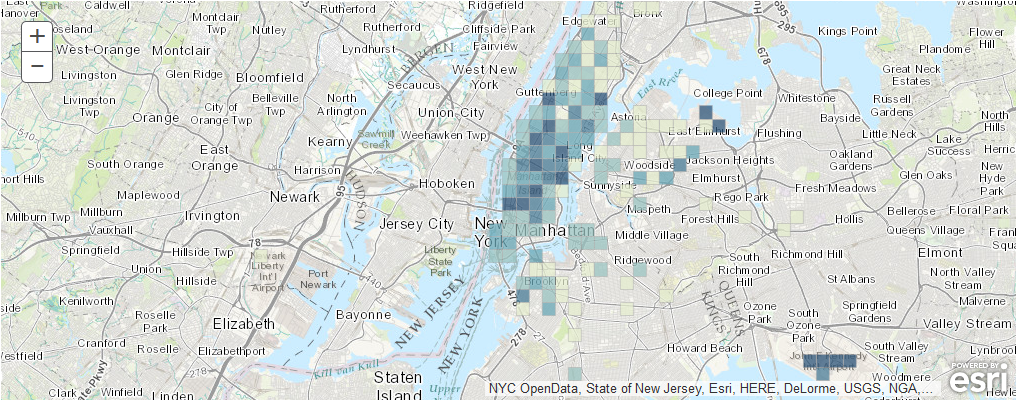

In [3]:
map2 = gis.map("New York, NY", 11)
map2

In [ ]:
map2.add_layer(agg_result, {
                "renderer":"ClassedColorRenderer",
                "field_name":"MAX_tip_amount", 
                "normalizationField":'MAX_trip_distance',
                "classificationMethod":'natural-breaks',
                "opacity":0.75
              })

We can now start seeing patterns, such as which pickup areas resulted in higher tips for the cab drivers.